In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../parameters/params.yaml'
import yaml
import sys
import os
with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

#data_folder = doc['data_folder']
#tissues = doc['tissues'].split(',')
#sys.path.append(doc['pipeline_path'])
ref_fa = doc['GENOME_FA']
#anno_gff=doc['annotation']
#mRNA_peak_file = doc["mRNA_peak_file"]
#tss_annotation = doc['tss_annotation']

from tss.visualize.fig_utils import helper_save
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from os.path import join
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
#from Homer import *

homer_path =  "/data2/resources/software/homer/v4.11_10242019/bin/"
os.environ['PATH'] = f"{homer_path}:{os.environ['PATH']}"
!which homer

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


params {'PREFIX': 'ncbi_pice_103', 'ROOT_DIR': '/data/isshamie/TSS/', 'DATA_DIR': '/data/isshamie/TSS/NCBI_PICR_103_Processed/', 'DATA_PROCESSED_DIR': '/data/isshamie/TSS/TSS/data/processed/', 'SUPPLEMENTAL_DIR': '/data/isshamie/TSS/Analysis/supplemental/', 'PIPELINE': '/data/isshamie/TSS/tss', 'GENOME_DIR': '/data/isshamie/genome', 'GENOME_FA': '/data/isshamie/genome/picr.fa', 'GENOME_GFF3': '/data/isshamie/genome/updated_final_sort.gff3', 'GENOME_GTF': '/data/isshamie/genome/updated_final_sort.gtf', 'TISSUES': 'BMDM1hKLA,BMDMwt,Brain,FemaleReproductive,Heart,Intestine,', 'META_FILE': '/data/isshamie/TSS/TSS/parameters/raw_metaSamples.tsv'}
/data2/resources/software/homer/v4.11_10242019/bin//homer


In [2]:
os.chdir(doc["results"])

genome="GCF"
save_dir = join("compare_tissues_distance", "GCF")

In [3]:
eTSS_meta = pd.read_csv(join(genome, "eTSS", "TSS.meta.tsv"), sep="\t", index_col=0)
eTSS_meta.head()

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental,has ATAC
p2@Bmp4_XM_027386529.1,"FemaleReproductive,MiscOrgans,Lung,Kidney,Musc...",0b00,NaN,90264.0,Bmp4,NaN,XM_027386529.1,1,0
p3@Bmp4_XM_027386529.1,"FemaleReproductive,MiscOrgans,Lung,Kidney,Musc...",0b00,NaN,181215.0,Bmp4,NaN,XM_027386529.1,1,1
p1@Bmp4_XM_027386529.1,"FemaleReproductive,MiscOrgans,Lung,Kidney,Musc...",0b11,NaN,348823.0,Bmp4,NaN,XM_027386529.1,1,1
p1@Bmp4_XM_027386528.1,"MiscOrgans,FemaleReproductive,Lung,Kidney,BMDM...",0b11,NaN,308710.0,Bmp4,NaN,XM_027386528.1,1,1
p1@Cdkn3_XM_027386531.1,"FemaleReproductive,MiscOrgans,Lung,BMDMwt,Musc...",0b11,NaN,237253.0,Cdkn3,NaN,XM_027386531.1,1,0


In [4]:
df = pickle.load(open(join(genome,"gene_centric_tss/txn_df_tissues.p"), "rb"))
df

,peaks,closest_to_X_numberOfPeaks,bin_-1000_1000,sameStrand_bin_-1000_1000,samples,minDistance,minDistancePeak,maxValue,maxPeakId,maxSample,Chr,Start,End,Strand,gene,transcript,maxSamples,hasGene,Number of SS,Tissues
XM_027386529.1,"[1394, 3038, 17726, 21888, 24414, 35067, 69088...",101,"[90264, 97971, 124234, 181215, 317724, 348823]","[90264, 181215, 348823]","[MiscOrgans_START1_and_MiscOrgans_startinput1,...",63.0,348823,5.91169,348823,NaN,NW_020822366.1,722245,722245,-,Bmp4,XM_027386529.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,3,"FemaleReproductive,MiscOrgans,Lung,Kidney,Musc..."
XM_027386528.1,"[17698, 163408, 224556, 226028, 268860, 275685...",28,"[163408, 308710]",[308710],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",27.0,308710,13.5345,308710,NaN,NW_020822366.1,724583,724583,-,Bmp4,XM_027386528.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1,"MiscOrgans,FemaleReproductive,Lung,Kidney,BMDM..."
XM_027386531.1,"[17679, 17707, 83014, 89129, 99005, 108459, 10...",29,"[138244, 237253]",[237253],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",74.0,237253,4.0268,237253,NaN,NW_020822366.1,1085509,1085509,+,Cdkn3,XM_027386531.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1,"FemaleReproductive,MiscOrgans,Lung,BMDMwt,Musc..."
XM_027386533.1,"[68904, 137124, 249586, 270147, 335001, 400304...",7,[],[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0,
XM_027386534.1,"[14157, 68988, 69200, 116089, 132667, 167473, ...",17,"[132667, 298307, 350581, 353645]",[298307],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",88.0,298307,5.86295,298307,NaN,NW_020822366.1,1114325,1114325,-,Cnih1,XM_027386534.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1,"MiscOrgans,FemaleReproductive,Lung,Kidney,BMDM..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XM_027434589.1,[],0,[],[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0,
XM_027434591.1,[],0,[],[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0,
XM_027434593.1,[],0,[],[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0,
XM_027434595.1,"[141900, 207964]",2,[],[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0,


In [5]:
gene_alt_distribution = pd.DataFrame(index=df["gene"].unique(), columns=["Number of promoters", "promoter distribution"])
for ind, val in df.groupby("gene"):
    print(ind)
    val["Num Tissues"] = val["Tissues"].apply(lambda x: len(x.split(",")))
    gene_alt_distribution.at[ind, "Number of promoters"] =  len(val)
    gene_alt_distribution.at[ind, "promoter distribution"] = np.sort(val["Num Tissues"].values)[::-1]
gene_alt_distribution["Number of promoters"] = gene_alt_distribution["Number of promoters"].fillna(0)
gene_alt_distribution = gene_alt_distribution[~(gene_alt_distribution.index.isnull())]

A1cf
A4galt
Aaas
Aacs
Aadac
Aadacl3
Aagab
Aak1
Aamdc
Aamp
Aar2
Aars
Aarsd1
Aasdh
Aass
Aatf
Aatk
Abat
Abca1
Abca2
Abca3
Abca5
Abca7
Abca9
Abcb1
Abcb10
Abcb11
Abcb1b
Abcb4
Abcb6
Abcb7
Abcb8
Abcb9
Abcc1
Abcc10
Abcc2
Abcc3
Abcc4
Abcc5
Abcc6
Abcc8
Abcc9
Abcd1
Abcd2
Abcd3
Abcd4
Abce1
Abcf1
Abcf2
Abcf3
Abcg1
Abcg2
Abcg4
Abcg5
Abcg8
Abhd1
Abhd10
Abhd11
Abhd12
Abhd13
Abhd14a
Abhd14b
Abhd16a
Abhd17a
Abhd17b
Abhd17c
Abhd18
Abhd2
Abhd3
Abhd5
Abhd6
Abhd8
Abi1
Abi2
Abi3
Abl1
Abl2
Ablim1
Ablim2
Abo
Abr
Abracl
Abraxas1
Abt1
Abtb1
Abtb2
Acaa2
Acacb
Acad10
Acad11
Acad9
Acadl
Acadm
Acads
Acadsb
Acadvl
Acap1
Acap2
Acap3
Acat1
Acbd3
Acbd4
Acbd5
Acbd6
Acbd7
Accs
Acd
Ace
Ace2
Acer1
Acer2
Acer3
Ache
Ackr3
Ackr4
Acmsd
Aco1
Aco2
Acod1
Acot11
Acot12
Acot13
Acot6
Acot7
Acot8
Acot9
Acox1
Acox2
Acox3
Acoxl
Acp1
Acp2
Acp5
Acp6
Acpp
Acsbg2
Acsf2
Acsf3
Acsl1
Acsl3
Acsl4
Acsl5
Acsl6
Acsm3
Acsm5
Acss1
Acss2
Acss3
Acta1
Acta2
Actc1
Actg2
Actl6a
Actl6b
Actn1
Actn2
Actn3
Actn4
Actr10
Actr1a

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.



Actr1b
Actr2
Actr3
Actr3b
Actr5
Actr6
Actr8
Actrt3
Acvr1
Acvr1c
Acvr2a
Acvr2b
Acy1
Acy3
Acyp1
Acyp2
Ada
Adal
Adam10
Adam11
Adam12
Adam15
Adam17
Adam19
Adam22
Adam23
Adam33
Adam9
Adamdec1
Adamts1
Adamts12
Adamts13
Adamts14
Adamts15
Adamts16
Adamts17
Adamts18
Adamts19
Adamts2
Adamts3
Adamts4
Adamts5
Adamts6
Adamts7
Adamts9
Adamtsl4
Adamtsl5
Adap1
Adap2
Adar
Adarb1
Adat1
Adat2
Adat3
Adck1
Adck2
Adck5
Adcy1
Adcy10
Adcy2
Adcy3
Adcy4
Adcy5
Adcy6
Adcy7
Adcy9
Adcyap1
Adcyap1r1
Add1
Add2
Adgra1
Adgra2
Adgra3
Adgrb1
Adgrb2
Adgrb3
Adgrd1
Adgre1
Adgre5
Adgrf1
Adgrf4
Adgrf5
Adgrg1
Adgrg3
Adgrg5
Adgrg6
Adgrl1
Adgrl2
Adgrl3
Adgrl4
Adgrv1
Adh5
Adh7
Adhfe1
Adi1
Adig
Adipoq
Adipor1
Adipor2
Adk
Adm
Adm2
Adnp
Adnp2
Adora1
Adora2a
Adora2b
Adpgk
Adprh
Adprm
Adra1a
Adra1b
Adra2b
Adra2c
Adrb2
Adrb3
Adrm1
Adsl
Adss
Adssl1
Adtrp
Aebp1
Aebp2
Aen
Aes
Afap1
Afap1l1
Afap1l2
Afdn
Aff1
Aff2
Aff3
Aff4
Afg1l
Afg3l2
Afm
Afmid
Aftph
Aga
Agap2
Agap3
Agbl2
Agbl3
Agbl5
Ager
Agfg1
Agfg2
Aggf1
Agk
Agl
Agmat
Agmo
Ago2
Ago3
Ag

CUNH21orf62
CUNH22orf15
CUNH2orf40
CUNH2orf50
CUNH2orf68
CUNH2orf69
CUNH2orf70
CUNH2orf80
CUNH2orf88
CUNH3orf18
CUNH3orf33
CUNH3orf38
CUNH3orf52
CUNH3orf62
CUNH3orf70
CUNH3orf86
CUNH4orf19
CUNH4orf3
CUNH4orf33
CUNH4orf54
CUNH5orf15
CUNH5orf24
CUNH5orf30
CUNH5orf49
CUNH5orf52
CUNH6orf118
CUNH6orf132
CUNH6orf203
CUNH6orf222
CUNH6orf226
CUNH6orf47
CUNH7orf31
CUNH7orf50
CUNH7orf57
CUNH8orf33
CUNH8orf34
CUNH8orf58
CUNH8orf59
CUNH8orf88
CUNH8orf89
CUNH9orf116
CUNH9orf152
CUNH9orf16
CUNH9orf24
CUNH9orf3
CUNH9orf40
CUNH9orf43
CUNH9orf78
CUNH9orf85
CUNHXorf21
CUNHXorf40A
CUNHXorf65
CUNHXorf67
CXHXorf38
CXHXorf56
Ca1
Ca10
Ca11
Ca12
Ca13
Ca14
Ca2
Ca3
Ca4
Ca5a
Ca5b
Ca7
Caap1
Cab39
Cab39l
Cabin1
Cables1
Cables2
Cabp1
Cabp2
Cabyr
Cacfd1
Cachd1
Cacna1a
Cacna1b
Cacna1f
Cacna1g
Cacna1s
Cacna2d1
Cacna2d2
Cacna2d3
Cacna2d4
Cacnb1
Cacnb2
Cacnb3
Cacnb4
Cacng1
Cacng3
Cacng4
Cacng7
Cacul1
Cacybp
Cad
Cadm1
Cadm2
Cadm3
Cadps2
Cage1
Calb1
Calb2
Calcoco2
Calcr
Calcrl
Cald1
Calhm3
Calhm5
Calm1
Calm2
Calm3
Calml5


Cyth4
Cytip
Cytl1
Cyyr1
Czib
D2hgdh
Daam1
Daam2
Dab1
Dab2
Dab2ip
Dach1
Dact2
Dad1
Dag1
Dagla
Daglb
Dalrd3
Dap3
Dapk1
Dapk2
Dapk3
Dapl1
Dapp1
Dars
Dars2
Daw1
Daxx
Dazap1
Dazap2
Dbf4
Dbi
Dbn1
Dbndd2
Dbnl
Dbp
Dbr1
Dcaf1
Dcaf10
Dcaf11
Dcaf12
Dcaf13
Dcaf15
Dcaf17
Dcaf4
Dcaf5
Dcaf6
Dcaf7
Dcaf8
Dcakd
Dcbld1
Dcbld2
Dcdc1
Dcdc2c
Dchs1
Dchs2
Dck
Dclk1
Dclk2
Dclre1a
Dclre1c
Dcn
Dcp1a
Dcp1b
Dcp2
Dcps
Dct
Dctd
Dctn1
Dctn2
Dctn3
Dctn4
Dctn6
Dctpp1
Dcun1d1
Dcun1d2
Dcun1d3
Dcun1d4
Dcun1d5
Dcx
Dcxr
Ddah1
Ddah2
Ddb1
Ddb2
Ddc
Ddhd2
Ddias
Ddit3
Ddit4
Ddit4l
Ddn
Ddost
Ddr1
Ddr2
Ddrgk1
Ddx1
Ddx10
Ddx11
Ddx17
Ddx18
Ddx19b
Ddx20
Ddx21
Ddx23
Ddx24
Ddx25
Ddx27
Ddx31
Ddx39a
Ddx39b
Ddx3x
Ddx4
Ddx41
Ddx42
Ddx46
Ddx49
Ddx5
Ddx50
Ddx51
Ddx52
Ddx54
Ddx55
Ddx56
Ddx58
Ddx59
Ddx6
Ddx60
Deaf1
Decr1
Dedd
Def6
Def8
Defb1
Defb124
Defb135
Dek
Dele1
Dennd1a
Dennd1b
Dennd1c
Dennd2a
Dennd2c
Dennd2d
Dennd3
Dennd4a
Dennd4b
Dennd4c
Dennd5a
Dennd5b
Dennd6a
Dennd6b
Denr
Depdc1
Depdc1b
Depdc5
Depdc7
Depp1
Dera
Derl1
Derl2
Des
Desi1
D

Fyb2
Fyco1
Fyn
Fyttd1
Fzd1
Fzd10
Fzd2
Fzd3
Fzd4
Fzd5
Fzd6
Fzd7
Fzr1
G0s2
G2e3
G3bp1
G3bp2
G6pc
G6pc2
G6pc3
G6pd
Gaa
Gab1
Gab2
Gab3
Gabarap
Gabarapl1
Gabarapl2
Gabbr1
Gabbr2
Gabpa
Gabpb1
Gabpb2
Gabra1
Gabra2
Gabra3
Gabra4
Gabra5
Gabra6
Gabrd
Gabre
Gabrg1
Gabrq
Gabrr2
Gad1
Gad2
Gadd45b
Gadd45g
Gadd45gip1
Gak
Gal
Gal3st1
Gal3st2
Gal3st3
Gal3st4
Galc
Gale
Galk1
Galk2
Galm
Galnt1
Galnt10
Galnt11
Galnt12
Galnt13
Galnt15
Galnt16
Galnt17
Galnt2
Galnt3
Galnt6
Galnt7
Galnt9
Galp
Galr2
Galt
Gamt
Gan
Ganc
Gap43
Gapdh
Gapt
Gapvd1
Gar1
Garem2
Garnl3
Gars
Gart
Gas2
Gas2l1
Gas2l2
Gas2l3
Gas6
Gas7
Gas8
Gask1a
Gask1b
Gata1
Gata2
Gata3
Gata5
Gata6
Gatad1
Gatad2a
Gatad2b
Gatb
Gatd1
Gatd3a
Gatm
Gba
Gba2
Gbe1
Gbf1
Gbgt1
Gbp5
Gc
Gca
Gcat
Gcc1
Gcc2
Gcdh
Gcfc2
Gcg
Gcgr
Gch1
Gchfr
Gck
Gckr
Gclm
Gcm1
Gcn1
Gcnt1
Gcnt3
Gcnt4
Gcsam
Gcsh
Gda
Gdap1
Gdap1l1
Gdap2
Gde1
Gdf10
Gdf11
Gdf2
Gdf9
Gdi1
Gdi2
Gdnf
Gdpd1
Gdpd2
Gdpd3
Gdpgp1
Gem
Gemin2
Gemin4
Gemin5
Gemin6
Gemin8
Gen1
Get4
Gfap
Gfer
Gfi1
Gfi1b
Gfm1
Gfm2
Gfod1
Gfod

Kif5a
Kif5b
Kif5c
Kif6
Kif7
Kif9
Kifap3
Kifc1
Kifc2
Kifc3
Kin
Kirrel1
Kirrel2
Kiss1r
Kit
Kitlg
Kiz
Kl
Klb
Klc1
Klc2
Klc4
Klf1
Klf10
Klf11
Klf15
Klf3
Klf4
Klf5
Klf6
Klf7
Klf8
Klf9
Klhdc10
Klhdc2
Klhdc3
Klhdc4
Klhdc7a
Klhdc8a
Klhdc8b
Klhdc9
Klhl1
Klhl10
Klhl11
Klhl12
Klhl13
Klhl14
Klhl15
Klhl17
Klhl18
Klhl2
Klhl20
Klhl21
Klhl22
Klhl23
Klhl24
Klhl25
Klhl26
Klhl28
Klhl29
Klhl3
Klhl30
Klhl31
Klhl34
Klhl36
Klhl4
Klhl40
Klhl41
Klhl42
Klhl6
Klhl7
Klhl8
Klhl9
Klk1
Klk11
Klk12
Klk13
Klk7
Klk8
Klkb1
Klrg1
Klrg2
Kmo
Kmt2a
Kmt2b
Kmt2d
Kmt2e
Kmt5a
Kmt5b
Kmt5c
Kncn
Kndc1
Kng1
Knl1
Knop1
Kpna2
Kpna3
Kpna4
Kpna5
Kpnb1
Kptn
Kras
Krba1
Krcc1
Kremen2
Kri1
Krit1
Krt13
Krt14
Krt15
Krt17
Krt18
Krt19
Krt4
Krt74
Krt80
Krtcap2
Krtdap
Ksr1
Ktn1
Ky
Kyat1
Kyat3
L1cam
L2hgdh
L3hypdh
L3mbtl2
L3mbtl3
LOC100689008
LOC100689011
LOC100689370
LOC100750340
LOC100750349
LOC100750364
LOC100750370
LOC100750375
LOC100750376
LOC100750406
LOC100750407
LOC100750411
LOC100750423
LOC100750424
LOC100750435
LOC100750439
LOC100750500

LOC100761846
LOC100761879
LOC100761889
LOC100761903
LOC100761951
LOC100761952
LOC100761963
LOC100761973
LOC100761975
LOC100762011
LOC100762018
LOC100762019
LOC100762026
LOC100762027
LOC100762049
LOC100762057
LOC100762078
LOC100762081
LOC100762083
LOC100762106
LOC100762115
LOC100762136
LOC100762189
LOC100762217
LOC100762240
LOC100762250
LOC100762252
LOC100762258
LOC100762270
LOC100762293
LOC100762310
LOC100762334
LOC100762355
LOC100762369
LOC100762372
LOC100762374
LOC100762377
LOC100762389
LOC100762413
LOC100762425
LOC100762433
LOC100762447
LOC100762478
LOC100762490
LOC100762526
LOC100762623
LOC100762631
LOC100762656
LOC100762660
LOC100762666
LOC100762669
LOC100762680
LOC100762688
LOC100762694
LOC100762701
LOC100762717
LOC100762719
LOC100762786
LOC100762819
LOC100762845
LOC100762860
LOC100762938
LOC100762960
LOC100762989
LOC100763014
LOC100763017
LOC100763057
LOC100763107
LOC100763140
LOC100763157
LOC100763162
LOC100763175
LOC100763181
LOC100763247
LOC100763249
LOC100763252
LOC100763253

LOC100772658
LOC100772688
LOC100772714
LOC100772719
LOC100772734
LOC100772735
LOC100772745
LOC100772751
LOC100772755
LOC100772759
LOC100772765
LOC100772772
LOC100772776
LOC100772792
LOC100772800
LOC100772834
LOC100772845
LOC100772866
LOC100772869
LOC100772892
LOC100772906
LOC100772912
LOC100772951
LOC100772956
LOC100772988
LOC100773005
LOC100773006
LOC100773020
LOC100773031
LOC100773059
LOC100773073
LOC100773089
LOC100773095
LOC100773119
LOC100773141
LOC100773144
LOC100773147
LOC100773172
LOC100773177
LOC100773204
LOC100773221
LOC100773237
LOC100773244
LOC100773249
LOC100773255
LOC100773256
LOC100773257
LOC100773299
LOC100773300
LOC100773314
LOC100773325
LOC100773326
LOC100773349
LOC100773351
LOC100773370
LOC100773381
LOC100773384
LOC100773391
LOC100773414
LOC100773418
LOC100773429
LOC100773431
LOC100773433
LOC100773435
LOC100773455
LOC100773462
LOC100773511
LOC100773521
LOC100773522
LOC100773524
LOC100773525
LOC100773531
LOC100773542
LOC100773545
LOC100773565
LOC100773571
LOC100773575

LOC113835352
LOC113835357
LOC113835359
LOC113835370
LOC113835377
LOC113835385
LOC113835397
LOC113835454
LOC113835465
LOC113835495
LOC113835514
LOC113835519
LOC113835543
LOC113835548
LOC113835615
LOC113835636
LOC113835641
LOC113835643
LOC113835651
LOC113835655
LOC113835663
LOC113835676
LOC113835685
LOC113835692
LOC113835711
LOC113835792
LOC113835797
LOC113835800
LOC113835828
LOC113835833
LOC113835842
LOC113835853
LOC113835857
LOC113835883
LOC113835903
LOC113835910
LOC113835924
LOC113835939
LOC113835958
LOC113836000
LOC113836005
LOC113836007
LOC113836021
LOC113836024
LOC113836085
LOC113836092
LOC113836094
LOC113836095
LOC113836103
LOC113836160
LOC113836173
LOC113836174
LOC113836182
LOC113836212
LOC113836246
LOC113836257
LOC113836269
LOC113836303
LOC113836304
LOC113836305
LOC113836306
LOC113836307
LOC113836308
LOC113836309
LOC113836310
LOC113836327
LOC113836331
LOC113836349
LOC113836353
LOC113836369
LOC113836375
LOC113836376
LOC113836408
LOC113836414
LOC113836417
LOC113836420
LOC113836423

Mmp17
Mmp19
Mmp2
Mmp21
Mmp24
Mmp24os
Mmp25
Mmp27
Mmp28
Mmp7
Mmp8
Mmp9
Mmrn2
Mms19
Mms22l
Mmut
Mn1
Mnat1
Mnd1
Mns1
Mnt
Moap1
Mob1a
Mob1b
Mob2
Mob3a
Mob3b
Mob3c
Mobp
Mocs1
Mocs2
Mog
Mogat1
Mogat2
Mogat3
Mogs
Mok
Mon1a
Mon1b
Mon2
Morc2
Morc3
Morc4
Morf4l1
Morf4l2
Morn1
Morn2
Morn3
Morn4
Morn5
Mosmo
Mospd1
Mospd2
Mospd3
Mov10
Moxd1
Mpc1
Mpc2
Mpdu1
Mpdz
Mpeg1
Mpg
Mphosph10
Mphosph6
Mphosph8
Mphosph9
Mpi
Mpig6b
Mplkip
Mpnd
Mpo
Mpp1
Mpp2
Mpp3
Mpp5
Mpp6
Mpp7
Mpped1
Mpped2
Mprip
Mpst
Mpv17
Mpv17l
Mpv17l2
Mpz
Mpzl1
Mpzl2
Mpzl3
Mrap
Mrap2
Mras
Mrc1
Mrc2
Mre11
Mreg
Mrgbp
Mrgprf
Mrgprg
Mri1
Mrm1
Mrm3
Mrnip
Mro
Mroh1
Mroh2a
Mroh6
Mrpl10
Mrpl11
Mrpl12
Mrpl13
Mrpl14
Mrpl15
Mrpl16
Mrpl17
Mrpl18
Mrpl19
Mrpl2
Mrpl20
Mrpl21
Mrpl23
Mrpl24
Mrpl3
Mrpl30
Mrpl32
Mrpl33
Mrpl34
Mrpl36
Mrpl37
Mrpl38
Mrpl39
Mrpl4
Mrpl40
Mrpl41
Mrpl42
Mrpl43
Mrpl44
Mrpl45
Mrpl46
Mrpl47
Mrpl48
Mrpl49
Mrpl50
Mrpl51
Mrpl52
Mrpl53
Mrpl54
Mrpl55
Mrpl57
Mrpl58
Mrpl9
Mrps10
Mrps11
Mrps12
Mrps14
Mrps15
Mrps17
Mrps18b
Mrps18c
Mrps2
Mrps21
M

Phlda2
Phlda3
Phldb1
Phldb2
Phldb3
Phlpp1
Phlpp2
Phospho1
Phospho2
Phpt1
Phrf1
Phtf1
Phtf2
Phyh
Phyhd1
Phyhipl
Phykpl
Pi15
Pi16
Pi4k2a
Pi4k2b
Pi4ka
Pi4kb
Pianp
Pias1
Pias2
Pias3
Pias4
Pibf1
Picalm
Pick1
Pid1
Pidd1
Piezo1
Piezo2
Pif1
Pifo
Piga
Pigb
Pigc
Pigf
Pigg
Pigh
Pigk
Pigl
Pigm
Pign
Pigo
Pigp
Pigq
Pigr
Pigs
Pigt
Pigu
Pigv
Pigw
Pigy
Pigz
Pih1d1
Pih1d2
Pih1d3
Pik3ap1
Pik3c2a
Pik3c2b
Pik3c3
Pik3ca
Pik3cb
Pik3cd
Pik3cg
Pik3ip1
Pik3r1
Pik3r2
Pik3r4
Pik3r5
Pik3r6
Pikfyve
Pim1
Pim2
Pim3
Pin1
Pin4
Pink1
Pinlyp
Pinx1
Pip
Pip4k2a
Pip4k2b
Pip4k2c
Pip4p1
Pip4p2
Pip5k1a
Pip5k1c
Pip5kl1
Pipox
Pir
Pirt
Pisd
Pithd1
Pitpna
Pitpnb
Pitpnc1
Pitpnm1
Pitpnm2
Pitpnm3
Pitx2
Pitx3
Piwil3
Piwil4
Pja1
Pja2
Pkd1
Pkd2l1
Pkd2l2
Pkdcc
Pkdrej
Pkhd1
Pkhd1l1
Pkia
Pkib
Pkig
Pkm
Pkmyt1
Pkn1
Pkn2
Pkn3
Pknox1
Pknox2
Pkp1
Pkp2
Pkp3
Pkp4
Pla1a
Pla2g10
Pla2g12a
Pla2g12b
Pla2g15
Pla2g2c
Pla2g2e
Pla2g3
Pla2g4a
Pla2g4c
Pla2g4e
Pla2g5
Pla2g6
Pla2r1
Plaa
Plac1
Plac8
Plac9
Plagl1
Plagl2
Plat
Plau
Plaur
Plbd1
Plbd2
Plcb1
Plcb2
P

Rplp0
Rplp1
Rplp2
Rpn1
Rpn2
Rpp14
Rpp25
Rpp25l
Rpp30
Rpp38
Rpp40
Rprd1a
Rprd1b
Rprd2
Rprm
Rps10
Rps11
Rps12
Rps13
Rps14
Rps15
Rps15a
Rps16
Rps17
Rps18
Rps19
Rps19bp1
Rps2
Rps20
Rps21
Rps23
Rps25
Rps26
Rps27
Rps27a
Rps27l
Rps3
Rps3a
Rps4x
Rps5
Rps6ka1
Rps6ka3
Rps6ka4
Rps6ka5
Rps6kb1
Rps6kb2
Rps6kc1
Rps6kl1
Rps7
Rps8
Rps9
Rpsa
Rptor
Rpusd1
Rpusd4
Rrad
Rraga
Rragb
Rragc
Rragd
Rras
Rras2
Rrbp1
Rreb1
Rrh
Rrm1
Rrm2
Rrm2b
Rrn3
Rrnad1
Rrp1
Rrp12
Rrp15
Rrp1b
Rrp8
Rrp9
Rrs1
Rs1
Rsad1
Rsad2
Rsbn1l
Rsf1
Rsl1d1
Rsl24d1
Rsph1
Rsph14
Rsph3
Rsph4a
Rsph6a
Rsph9
Rspo1
Rspo2
Rspo4
Rspry1
Rsrc1
Rsrc2
Rsrp1
Rsu1
Rtbdn
Rtca
Rtcb
Rtel1
Rtf1
Rtf2
Rtkn
Rtkn2
Rtl3
Rtl6
Rtl9
Rtn2
Rtn3
Rtn4
Rtn4ip1
Rtn4r
Rtn4rl1
Rtn4rl2
Rtp1
Rtp2
Rtp3
Rtp4
Rtraf
Rttn
Rubcn
Rubcnl
Rufy1
Rufy2
Rufy3
Rufy4
Rundc1
Rundc3a
Rundc3b
Runx1
Runx1t1
Runx2
Runx3
Rusc1
Rusc2
Ruvbl1
Ruvbl2
Rwdd1
Rwdd2a
Rwdd2b
Rwdd3
Rwdd4
Rxfp1
Rxfp3
Rxfp4
Rxra
Rxrb
Rxrg
Rxylt1
Rybp
Ryk
Ryr1
S100a1
S100a10
S100a11
S100a13
S100a14
S100a16
S100a3
S100a4
S100a6
S

Srsf1
Srsf10
Srsf11
Srsf12
Srsf3
Srsf4
Srsf5
Srsf6
Srsf7
Srsf9
Srxn1
Ss18
Ss18l1
Ss18l2
Ssb
Ssbp1
Ssbp2
Ssbp3
Ssbp4
Ssc5d
Ssh1
Ssh2
Ssh3
Ssna1
Sspn
Ssr1
Ssr2
Ssr3
Ssr4
Ssrp1
Sst
Sstr1
Sstr2
Sstr3
Ssu72
Ssuh2
Ssx2ip
St13
St14
St3gal1
St3gal2
St3gal3
St3gal4
St3gal5
St3gal6
St5
St6gal2
St6galnac1
St6galnac2
St6galnac3
St6galnac4
St6galnac6
St7
St8sia1
St8sia2
St8sia3
St8sia4
St8sia5
Stab1
Stab2
Stac
Stac2
Stag1
Stag2
Stam
Stam2
Stambp
Stambpl1
Stap1
Stap2
Star
Stard10
Stard13
Stard3
Stard3nl
Stard4
Stard5
Stard7
Stard8
Stard9
Stat1
Stat3
Stat6
Stau1
Stau2
Stc1
Stc2
Steap1
Steap2
Steap3
Stil
Stim1
Stim2
Stip1
Stk10
Stk11
Stk11ip
Stk16
Stk17b
Stk19
Stk24
Stk25
Stk26
Stk3
Stk31
Stk32a
Stk32b
Stk32c
Stk36
Stk38
Stk38l
Stk39
Stk4
Stk40
Stkld1
Stmn1
Stmn2
Stmn3
Stmnd1
Stn1
Stom
Stoml1
Stoml2
Ston1
Ston2
Stox1
Stox2
Stpg1
Stpg3
Stra6
Strada
Stradb
Strap
Strbp
Strip1
Strip2
Strn
Strn3
Stt3a
Stub1
Stx11
Stx12
Stx16
Stx17
Stx18
Stx1a
Stx1b
Stx2
Stx3
Stx4
Stx5
Stx6
Stx7
Stxbp1
Stxbp2
Stxbp3
Stxbp4


Tut4
Tut7
Tvp23a
Tvp23b
Twf1
Twf2
Twistnb
Twsg1
Txlna
Txlnb
Txlng
Txn
Txn2
Txndc11
Txndc12
Txndc15
Txndc16
Txndc17
Txndc5
Txndc9
Txnip
Txnl1
Txnl4a
Txnl4b
Txnrd1
Txnrd2
Txnrd3
Tyk2
Tymp
Tyms
Tyro3
Tyrobp
Tyrp1
Tysnd1
Tyw3
Tyw5
U2af1
U2af2
U2surp
Uaca
Uap1
Uap1l1
Uba1
Uba2
Uba5
Uba6
Uba7
Ubac1
Ubald1
Ubald2
Ubap1
Ubap1l
Ubap2
Ubap2l
Ubash3a
Ubb
Ubc
Ubd
Ube2a
Ube2b
Ube2c
Ube2d1
Ube2d2
Ube2d4
Ube2e2
Ube2e3
Ube2f
Ube2g1
Ube2g2
Ube2h
Ube2i
Ube2j1
Ube2j2
Ube2k
Ube2l3
Ube2l6
Ube2m
Ube2o
Ube2q1
Ube2q2
Ube2ql1
Ube2r2
Ube2s
Ube2t
Ube2u
Ube2v1
Ube2v2
Ube2w
Ube2z
Ube3a
Ube3b
Ube3c
Ube3d
Ube4a
Ube4b
Ubfd1
Ubiad1
Ubl3
Ubl4a
Ubl5
Ubl7
Ublcp1
Ubn1
Ubn2
Ubox5
Ubp1
Ubqln1
Ubqln2
Ubqln4
Ubr1
Ubr2
Ubr4
Ubr5
Ubr7
Ubtd1
Ubtd2
Ubtf
Ubxn1
Ubxn10
Ubxn2a
Ubxn2b
Ubxn4
Ubxn6
Ubxn7
Ubxn8
Uchl1
Uchl3
Uchl5
Uck1
Uck2
Uckl1
Ucma
Ucn
Ucp1
Ucp2
Ucp3
Uevld
Ufc1
Ufd1
Ufl1
Ufm1
Ufsp1
Ugcg
Uggt1
Uggt2
Ugp2
Ugt2a3
Uhmk1
Uhrf1
Uhrf1bp1
Uhrf1bp1l
Uhrf2
Uimc1
Ulk1
Ulk2
Ulk3
Ulk4
Umad1
Umod
Umps
Unc119
Unc119b
Unc13a
Unc13b
Unc

In [6]:
max(gene_alt_distribution["promoter distribution"].apply(lambda x: len(x)))

10

In [7]:
gene_alt_distribution

,Number of promoters,promoter distribution
Bmp4,2,"[11, 8]"
Cdkn3,1,[8]
Cnih1,1,[13]
Cgrrf1,1,[13]
Samd4a,2,"[11, 3]"
...,...,...
LOC113839047,1,[13]
LOC113839066,1,[5]
LOC113839076,2,"[13, 5]"
LOC113839111,1,[11]


In [8]:
gene_alt_distribution_mat = pd.DataFrame(index=gene_alt_distribution.index,
                                         columns=np.arange(1,max(gene_alt_distribution["promoter distribution"].apply(lambda x: len(x)))+1))
for ind, val in gene_alt_distribution.iterrows():
    gene_alt_distribution_mat.loc[ind, np.arange(1,val["Number of promoters"]+1)] = val["promoter distribution"]

gene_alt_distribution_mat

,1,2,3,4,5,6,7,8,9,10
Bmp4,11,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cdkn3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cnih1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cgrrf1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Samd4a,11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
LOC113839047,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC113839066,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC113839076,13,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC113839111,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
gene_alt_distribution_mat["Number of promoters"] = gene_alt_distribution["Number of promoters"]
gene_alt_distribution_mat

,1,2,3,4,5,6,7,8,9,10,Number of promoters
Bmp4,11,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
Cdkn3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Cnih1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Cgrrf1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Samd4a,11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...
LOC113839047,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
LOC113839066,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
LOC113839076,13,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
LOC113839111,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


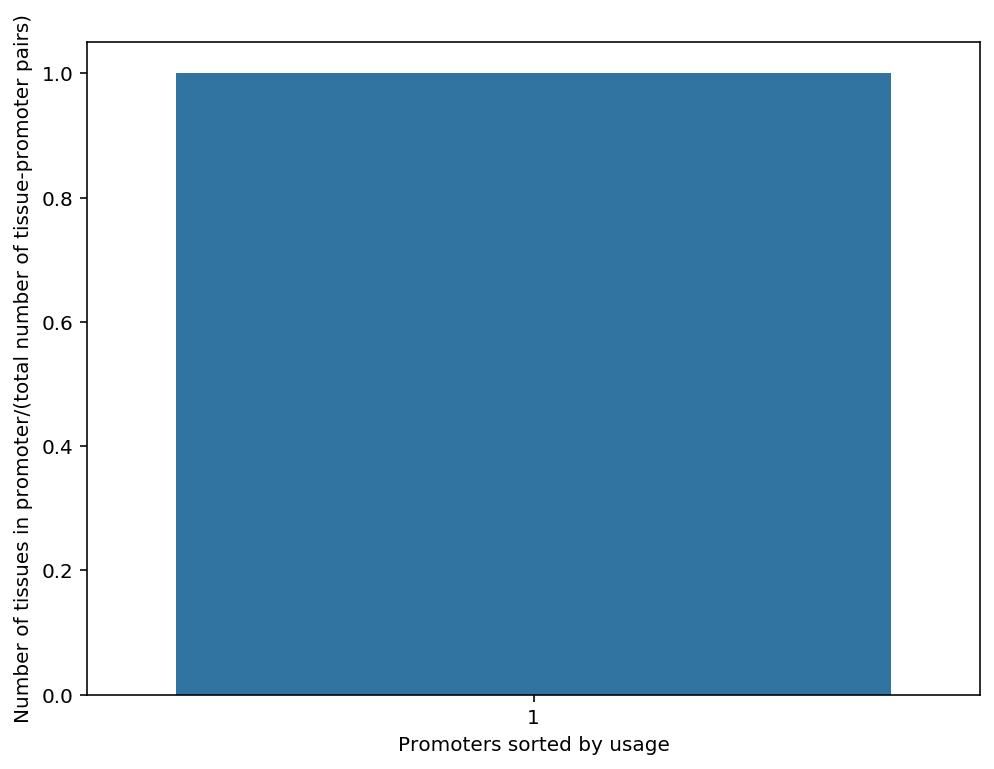

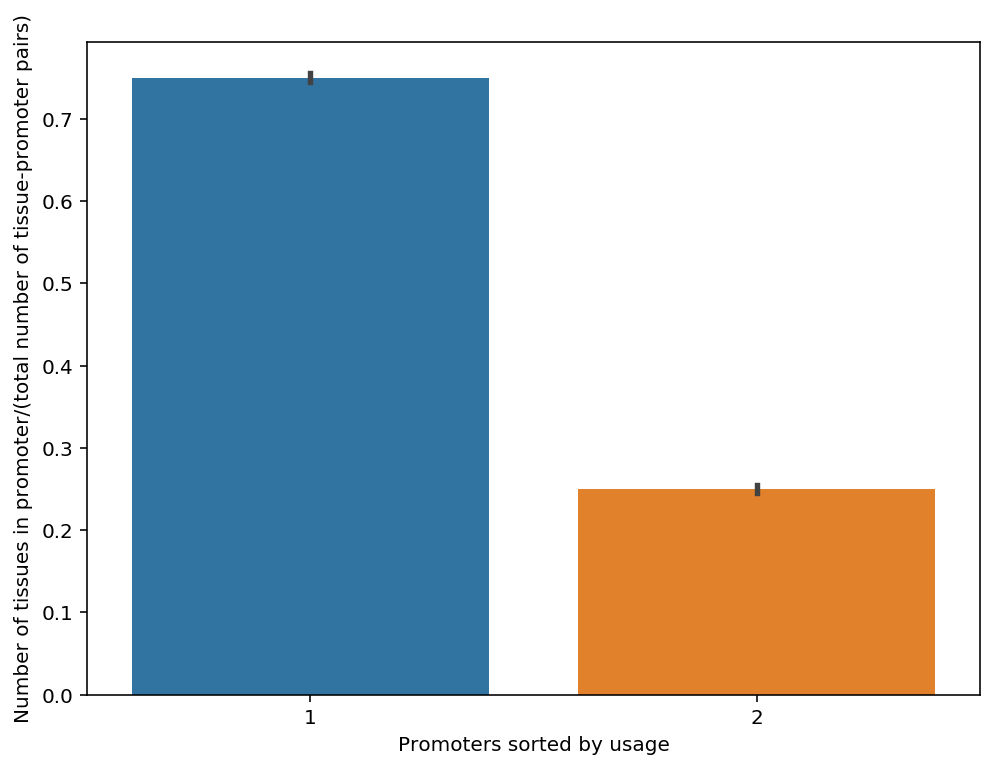

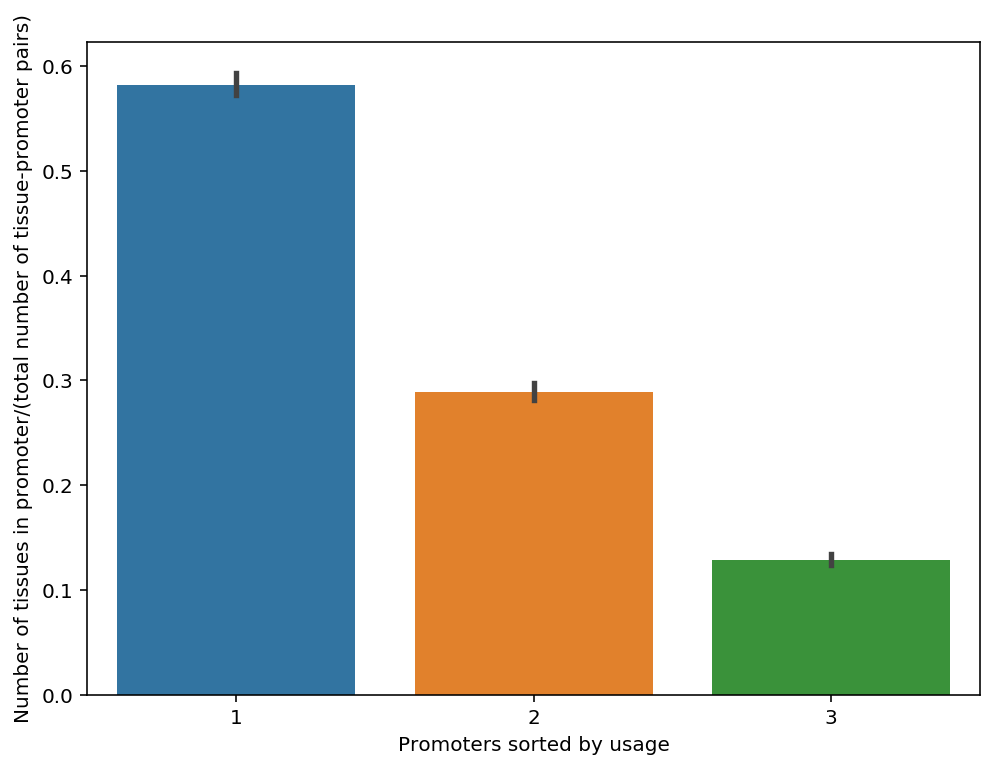

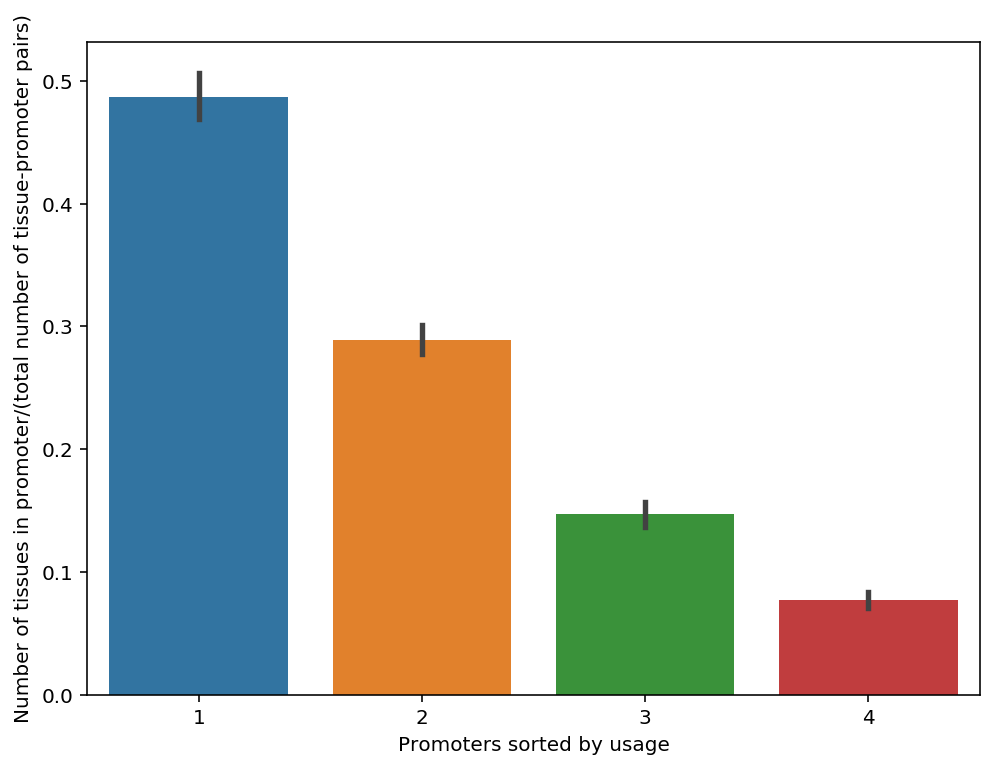

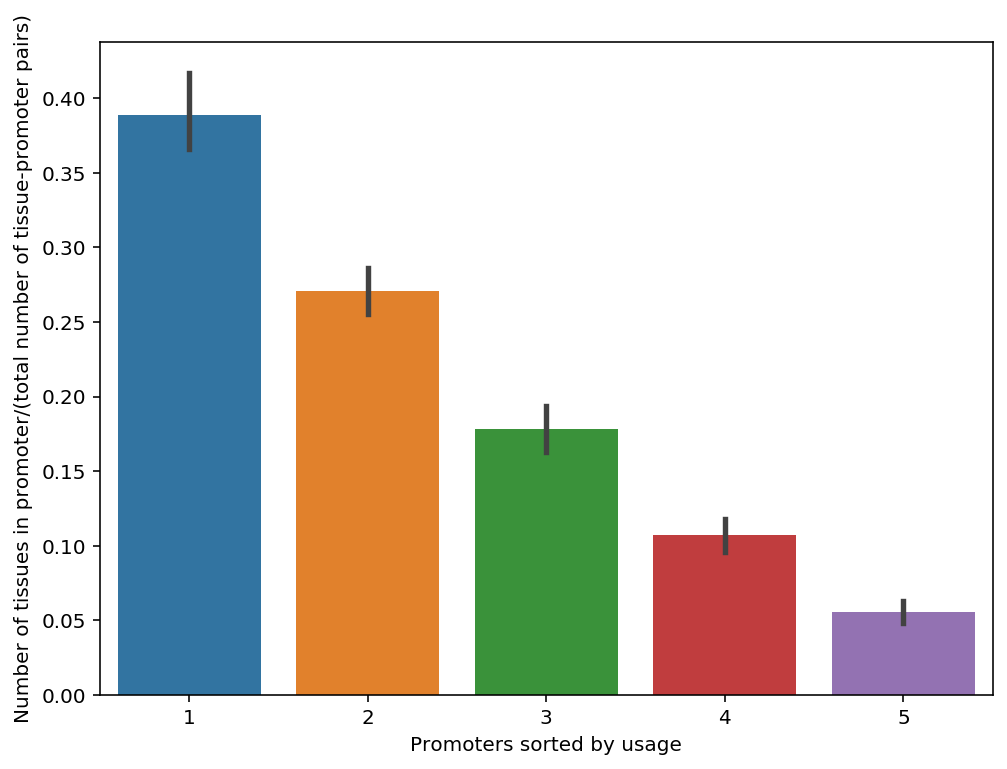

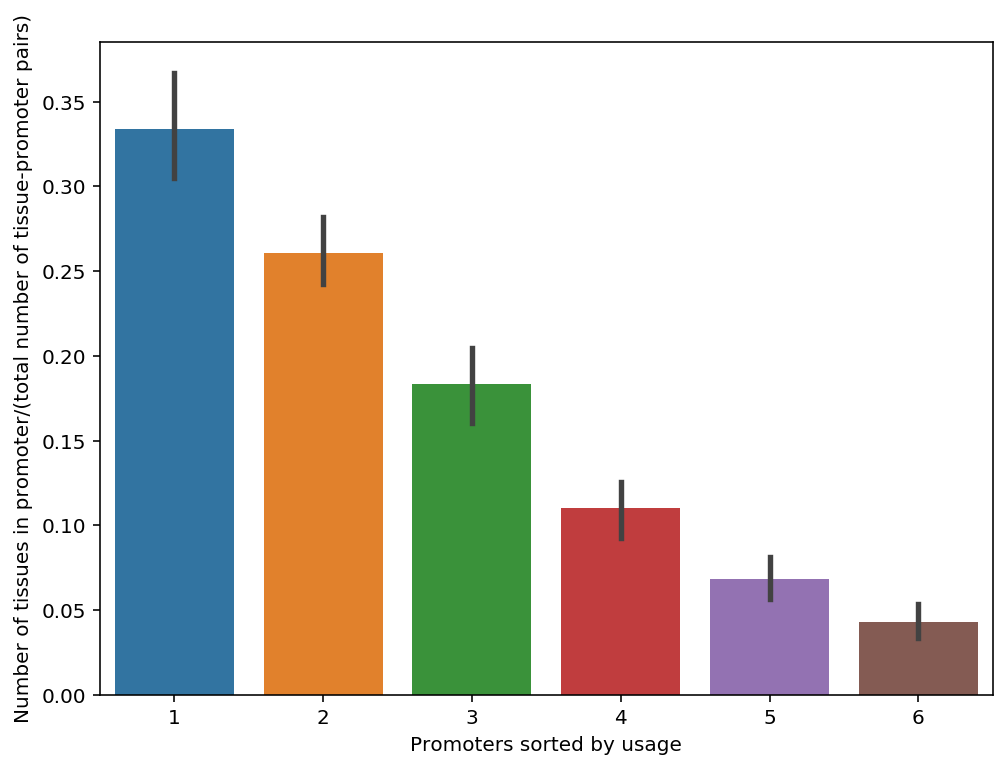

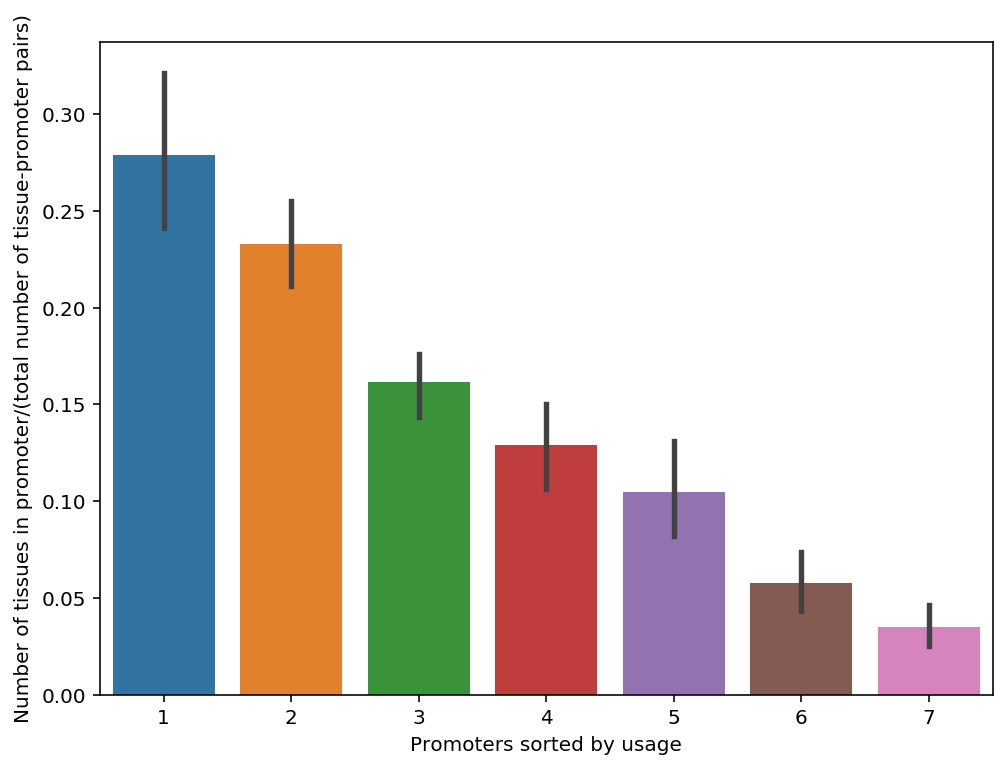

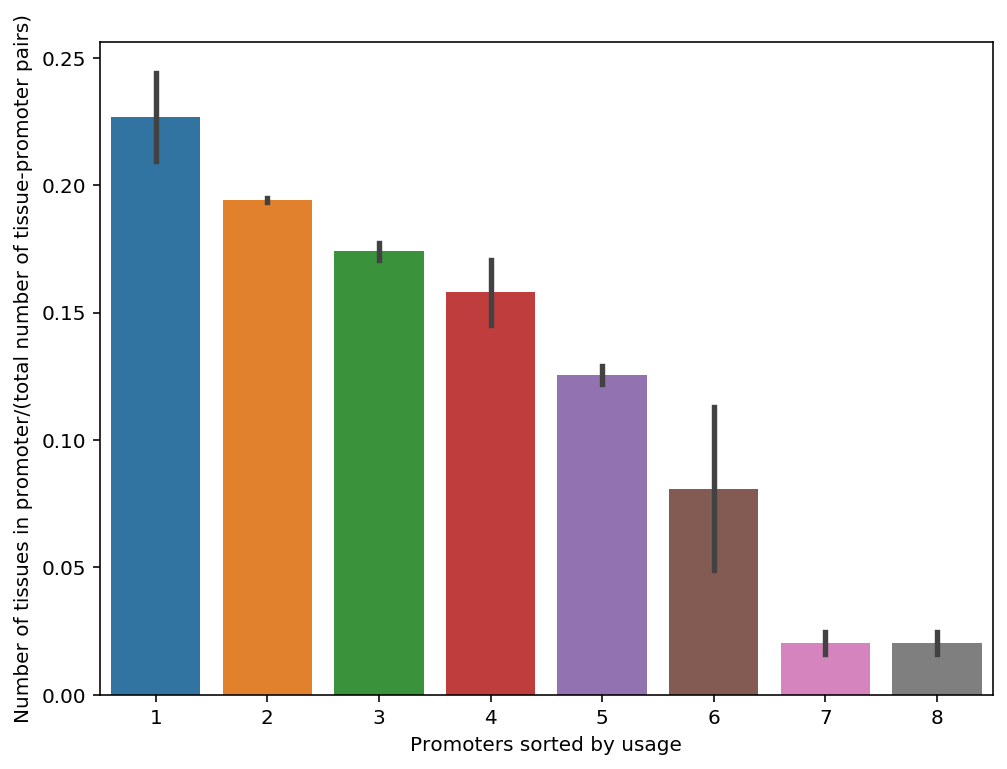

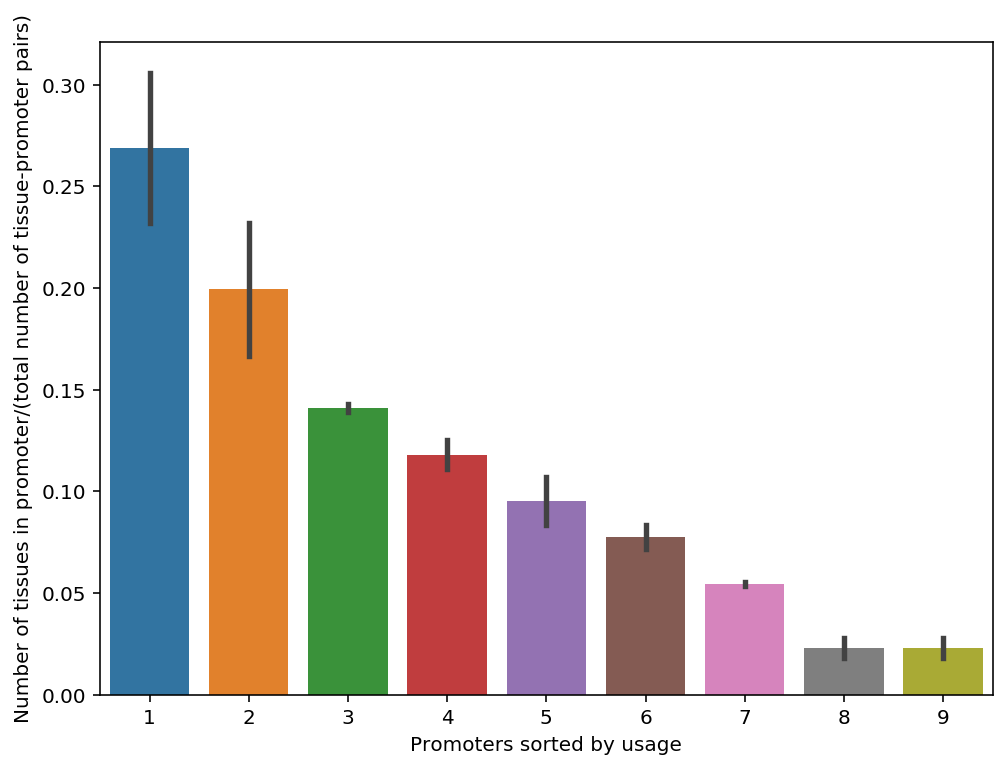

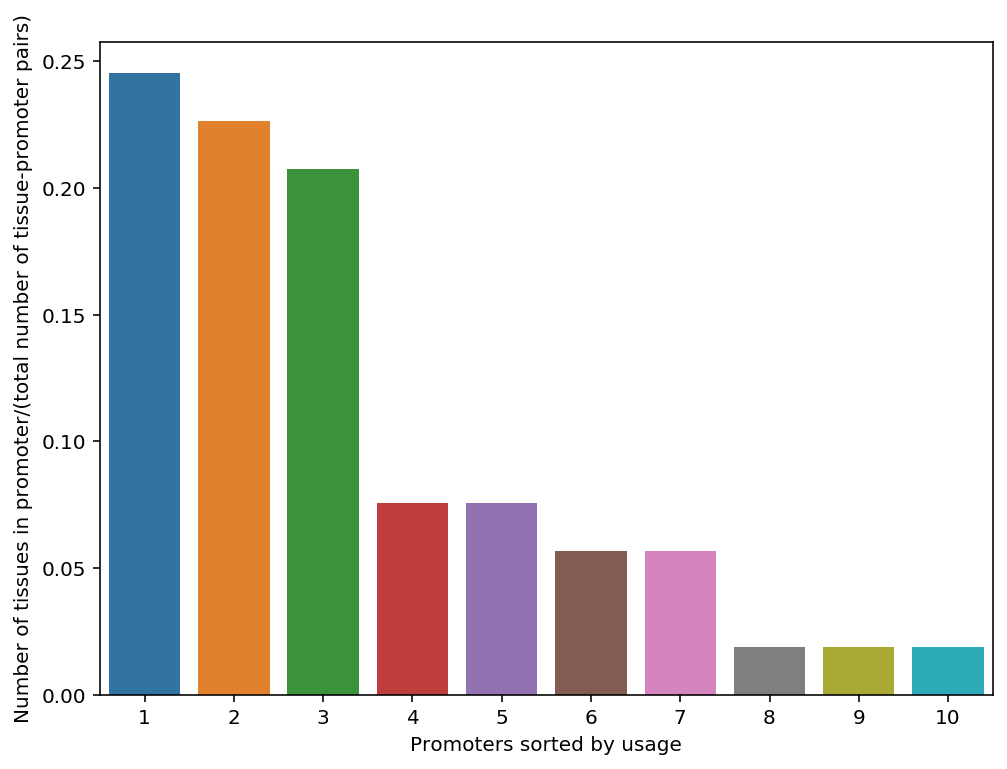

In [10]:
for ind, val in gene_alt_distribution_mat.groupby("Number of promoters", ):
    f = plt.figure()
#    print((1.0*val.astype(float))/val.astype(float)["Number of promoters"].values[0])
    sns.barplot(data=val.dropna(axis=1,how='any').astype(float).divide(val.drop("Number of promoters",axis=1).sum(axis=1).astype(float),axis='rows').drop("Number of promoters", axis=1))
    plt.xlabel("Promoters sorted by usage")
    plt.ylabel("Number of tissues in promoter/(total number of tissue-promoter pairs)")
    

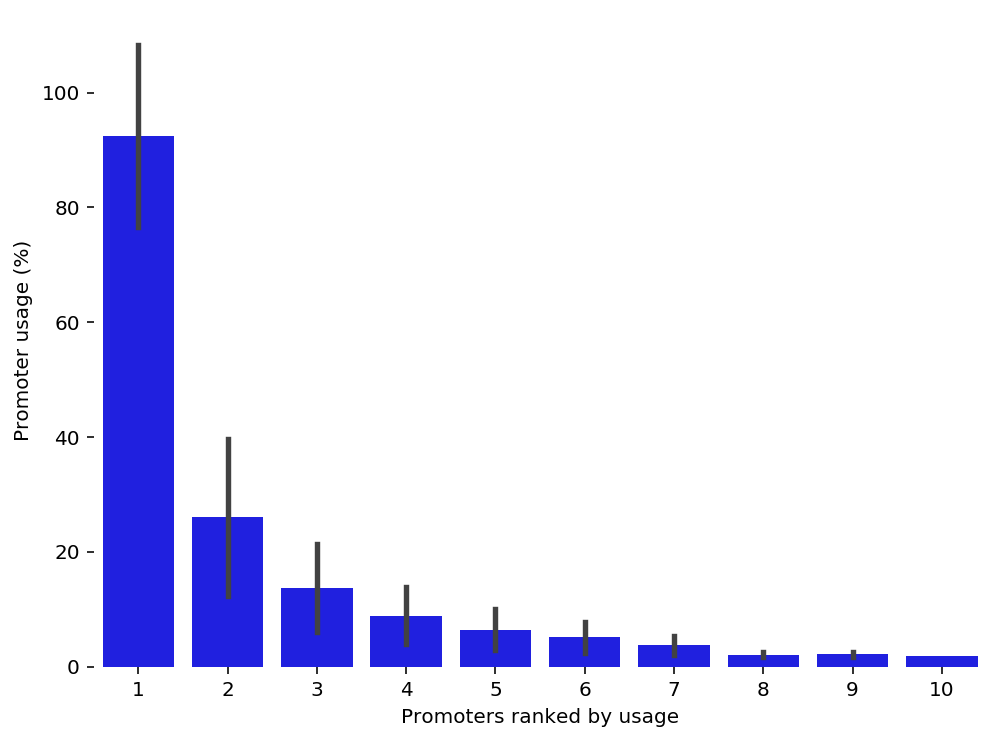

In [11]:
sns.barplot(data=100*gene_alt_distribution_mat.astype(float).divide(gene_alt_distribution_mat.drop("Number of promoters",axis=1).sum(axis=1).astype(float),axis='rows').drop("Number of promoters", axis=1),
           color='blue', ci="sd")
plt.ylabel("Promoter usage (%)")
plt.xlabel("Promoters ranked by usage")
helper_save(join(save_dir,"promoter_usage_ncbi.png"))

### Only use rows when more than one promoter

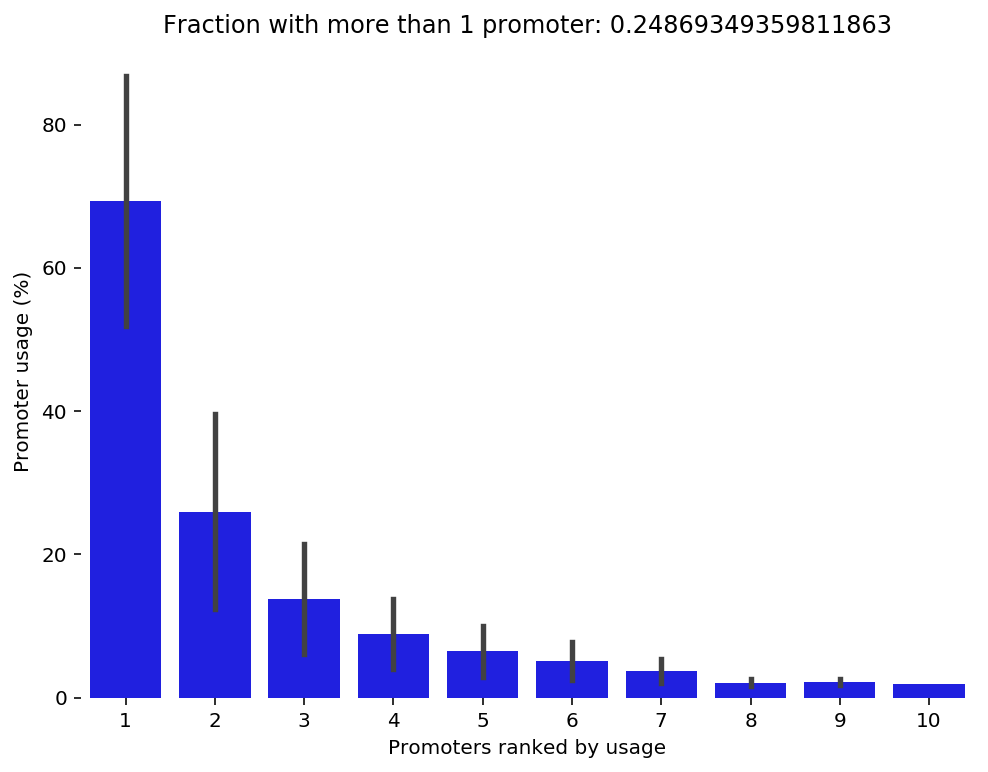

In [12]:
sns.barplot(data=100*gene_alt_distribution_mat[~(gene_alt_distribution_mat[2].isnull())].astype(float).divide(gene_alt_distribution_mat[~(gene_alt_distribution_mat[2].isnull())].drop("Number of promoters",axis=1).sum(axis=1).astype(float),axis='rows').drop("Number of promoters", axis=1),
           color='blue', ci="sd")
plt.title(f"Fraction with more than 1 promoter: {(~(gene_alt_distribution_mat[2].isnull())).sum()/gene_alt_distribution_mat.shape[0]}")
plt.ylabel("Promoter usage (%)")
plt.xlabel("Promoters ranked by usage")
helper_save(join(save_dir,"promoter_usage_moreThan1_ncbi.png"))

## Make entropy measure

In [13]:
from scipy.stats import entropy

(array([1.1501e+04, 7.3900e+02, 8.7700e+02, 1.3250e+03, 3.6600e+02,
        3.1500e+02, 1.0000e+02, 5.8000e+01, 1.9000e+01, 8.0000e+00]),
 array([0.        , 0.19530262, 0.39060523, 0.58590785, 0.78121047,
        0.97651308, 1.1718157 , 1.36711831, 1.56242093, 1.75772355,
        1.95302616]),
 <a list of 10 Patch objects>)

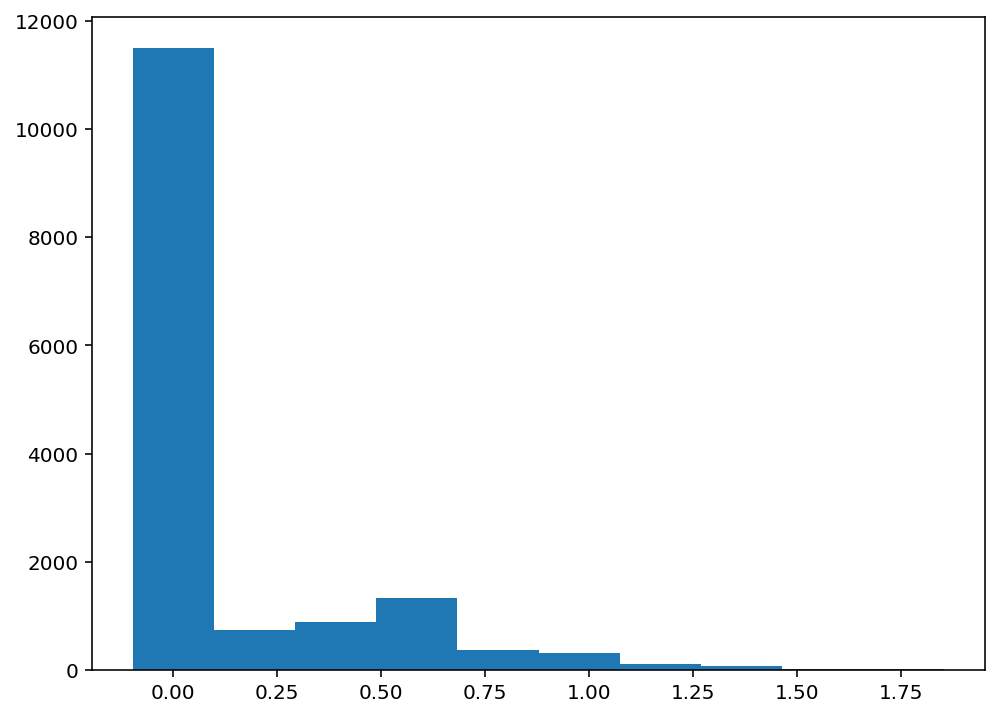

In [14]:
curr = gene_alt_distribution_mat.astype(float).divide(gene_alt_distribution_mat.drop("Number of promoters",axis=1).sum(axis=1).astype(float),axis='rows').drop("Number of promoters", axis=1)

plt.hist(curr.apply(lambda x: entropy(x.dropna()), axis=1), align='left')